# This is a notebook to evaluate the train/test split methods of clustered vs random

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve

In [51]:
datasets=['sol_del','clintox','bace','tox21','deepchem_Lipophilicity','HIV']

data_map={
    'HIV': {'target':'HIV_active','structure':'smiles'},
    'bace':{'target':'active','structure':'mol'},
    'tox21':{'target':'NR-AhR','structure':'smiles'},
    'clintox':{'target':'CT_TOX','structure':'smiles'},
    'sol_del':{'target':'binned_sol','structure':'smiles'},
    'deepchem_Lipophilicity':{'target':'drug_like','structure':'smiles'}   
}

In [52]:
results={'dataset':[],'split_type':[],'metric':[],'score':[],'model':[]}

def eval_metrics(y_true, y_pred,threshold):
    result={}
    # calculate those that want probabilities
    result.update({'log_loss' : log_loss(y_true,y_pred)})
    result.update({'roc_auc': roc_auc_score(y_true, y_pred)})
    # convert to scores based on threshold:
    y_pred=[1 if i>=threshold else 0 for i in y_pred]
    result.update({'accuracy': accuracy_score(y_true,y_pred)})
    result.update({'f1': f1_score(y_true,y_pred)})
    result.update({'matthews_corr': matthews_corrcoef(y_true,y_pred)})
    return(result)


In [111]:
def score_models(dataset,chemprop_target,simple_target):
    """ Takes in the dataset name, chemprop and simple predictions paths and then outputs
    the result as a dataframe with all of their scores. 
    """
    
    target=data_map[dataset]['target']
    smiles=data_map[dataset]['structure']
    # Make a merged dataframe:
    df_chemprop=pd.read_csv(chemprop_target)
    df_chemprop=df_chemprop[[smiles,target,'target_actual']]
    df_chemprop.rename(columns={target:'chemprop_pred'},inplace=True)
    
    # Get simple predictions:
    
    df=pd.read_csv(simple_target)
    df=df[[smiles,'target_actual','Random_Forest_prediction','SVM_prediction','Dummy_Most_Frequent_prediction',
        'Logistic_Regression_prediction','Gradient_Boosted_Tree_prediction','KNN_prediction']]
    # merge the data:
    df=df.merge(df_chemprop[[smiles,'chemprop_pred']],on=smiles,how='outer')
    
    # Scores with threshold of 0.5
    pred_cols=[i for i in list(df.columns) if i not in [smiles,'cluster','target_actual']]
    threshold=0.5
    scores={}
    for column in pred_cols:
        y_pred=df[column]
        y_true=df['target_actual']
        scores.update({column:eval_metrics(y_true, y_pred,threshold)})
    
    result=pd.DataFrame(scores).round(2).T
    result['dataset']=dataset
    # Add meta data columns:
    split_method=simple_target.split('-')[1]
    split_type=simple_target.split('-')[2]
    
    result['split_method']=split_method #cluster or random
    result['split_id']=split_type # train or val
    result.reset_index(inplace=True)
    result.rename(columns={'index':'model_type'},inplace=True)
    result['model_type']=result['model_type'].apply(lambda x: x.replace('_prediction',''))
                
    return(result)

In [112]:
result_dfs=[]
for file in os.listdir('../Simple_Models/Predictions'):
    dataset=file.split('-')[0]
    chemprop_target=os.path.join('../Complex_Models/Predictions/',file)
    simple_target=os.path.join('../Simple_Models/Predictions',file)
    
    result_dfs.append(score_models(dataset,chemprop_target,simple_target))

In [113]:
combined=pd.concat(result_dfs)
combined

,model_type,log_loss,roc_auc,accuracy,f1,matthews_corr,dataset,split_method,split_id
0,Random_Forest,0.29,0.91,0.86,0.53,0.49,sol_del,random,validate
1,SVM,0.33,0.90,0.85,0.47,0.43,sol_del,random,validate
2,Dummy_Most_Frequent,6.50,0.50,0.81,0.00,0.00,sol_del,random,validate
3,Logistic_Regression,0.32,0.89,0.86,0.51,0.49,sol_del,random,validate
4,Gradient_Boosted_Tree,0.42,0.74,0.84,0.22,0.32,sol_del,random,validate
...,...,...,...,...,...,...,...,...,...
2,Dummy_Most_Frequent,1.20,0.50,0.97,0.00,0.00,HIV,random,train
3,Logistic_Regression,0.09,0.90,0.97,0.45,0.50,HIV,random,train
4,Gradient_Boosted_Tree,0.13,0.74,0.97,0.10,0.21,HIV,random,train
5,KNN,0.05,0.98,0.98,0.57,0.59,HIV,random,train


In [114]:
df=combined.copy()

In [121]:
combined.to_csv('All_Eval_Results.csv')

In [116]:
df.head(5)
val_df=df[(df['split_id']=='validate')]
val_df

,model_type,log_loss,roc_auc,accuracy,f1,matthews_corr,dataset,split_method,split_id
0,Random_Forest,0.29,0.91,0.86,0.53,0.49,sol_del,random,validate
1,SVM,0.33,0.90,0.85,0.47,0.43,sol_del,random,validate
2,Dummy_Most_Frequent,6.50,0.50,0.81,0.00,0.00,sol_del,random,validate
3,Logistic_Regression,0.32,0.89,0.86,0.51,0.49,sol_del,random,validate
4,Gradient_Boosted_Tree,0.42,0.74,0.84,0.22,0.32,sol_del,random,validate
...,...,...,...,...,...,...,...,...,...
2,Dummy_Most_Frequent,1.09,0.50,0.97,0.00,0.00,clintox,cluster,validate
3,Logistic_Regression,0.19,0.48,0.97,0.00,0.00,clintox,cluster,validate
4,Gradient_Boosted_Tree,0.16,0.50,0.97,0.00,0.00,clintox,cluster,validate
5,KNN,0.99,0.47,0.97,0.00,0.00,clintox,cluster,validate


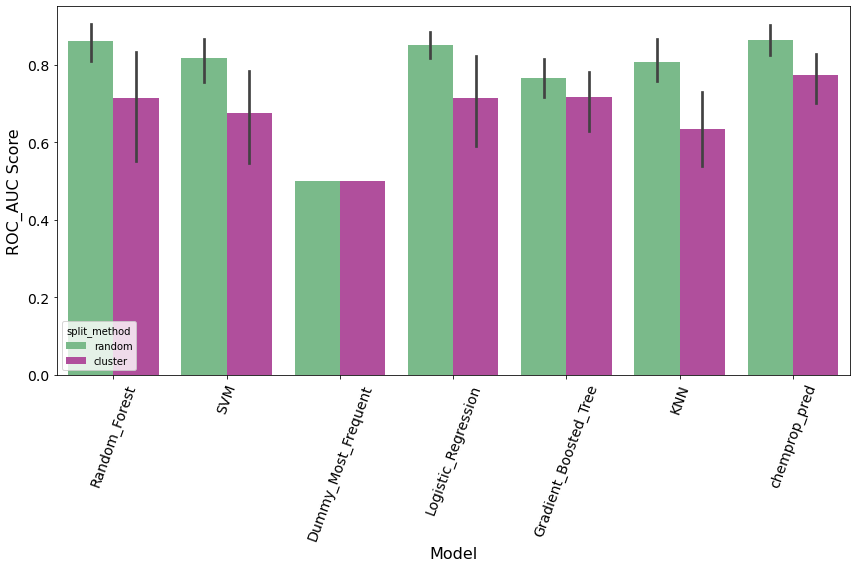

In [149]:
fig,axes=plt.subplots(1,figsize=(12,8))
dataset='bace'
sns.barplot(data=val_df,x='model_type',y='roc_auc',hue='split_method',
            axes=axes,palette=['#6FC584','#C03FA5'])
plt.xticks(rotation=70,size=14)
plt.yticks(size=14)
plt.ylabel('ROC_AUC Score',size=16)
plt.xlabel('Model',size=16)

plt.tight_layout()

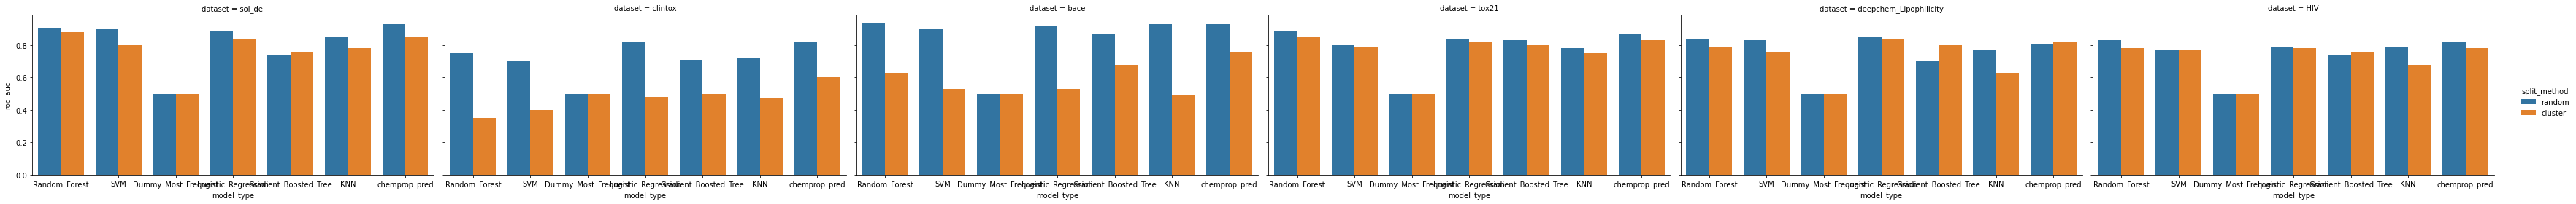

In [132]:
sns.catplot(data=val_df,x='model_type',y='roc_auc',hue='split_method',
            col='dataset',kind='bar',height=4, aspect=2)